In [122]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import layers, models


from tensorflow.keras.applications import MobileNet
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

from sklearn.metrics import ConfusionMatrixDisplay
import math
from sklearn.metrics import classification_report, roc_auc_score

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Data Preprocessing

## Image Rescaling

In [123]:
# train_path = 'archive/Training/'

# # x_train
# train_imgs = [cv2.resize(cv2.imread(os.path.join(train_path, folder, file_name)), (256, 256)) 
#              for folder in os.listdir(train_path) if folder != '.DS_Store'
#              for file_name in tqdm(os.listdir(os.path.join(train_path, folder)))]

# # y_train
# train_labels = [folder
#                 for folder in os.listdir(train_path) if folder != '.DS_Store'
#                 for file_name in os.listdir(os.path.join(train_path, folder))]


# test_path = 'archive/Testing/' 

# # x_test
# test_imgs = [cv2.resize(cv2.imread(os.path.join(test_path, folder, file_name)), (256, 256)) 
#              for folder in os.listdir(test_path) if folder != '.DS_Store'
#              for file_name in tqdm(os.listdir(os.path.join(test_path, folder)))]
# # y_test
# test_labels = [folder
#                 for folder in os.listdir(test_path) if folder != '.DS_Store'
#                 for file_name in os.listdir(os.path.join(test_path, folder))]

# train_imgs = np.array(train_imgs)
# test_imgs = np.array(test_imgs)

train_imgs = []
train_labels = []

test_imgs = []
test_labels = []

train_path = ('archive/Training/')
test_path = ('archive/Testing/')

img_size= 256
for i in os.listdir(train_path):
    for j in tqdm(os.listdir(train_path+i)):
        train_imgs.append(cv2.resize(cv2.imread(train_path+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(test_path):
    for j in tqdm(os.listdir(test_path+i)):
        test_imgs.append(cv2.resize(cv2.imread(test_path+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        
train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

100%|██████████| 74/74 [00:00<00:00, 429.28it/s]


## Visualizing Data

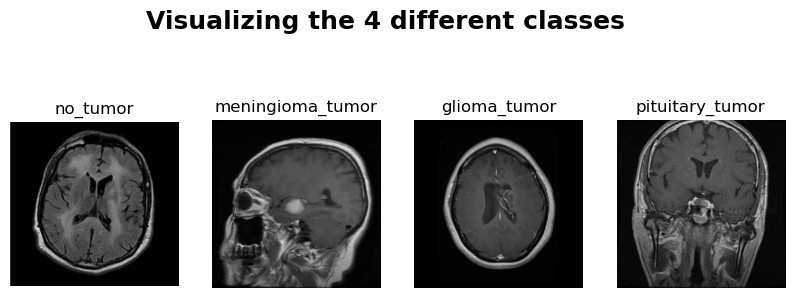

In [124]:
fig, ax = plt.subplots(1, 4, figsize=(10, 4))
fig.suptitle('Visualizing the 4 different classes', fontsize=18, fontweight='bold')

labels = [x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x))]

for i, label in enumerate(labels):
    img_path = os.path.join(train_path, label, os.listdir(os.path.join(train_path, label))[2])
    img = cv2.imread(img_path)
    ax[i].imshow(img)
    ax[i].set_title(label)
    ax[i].axis('off')

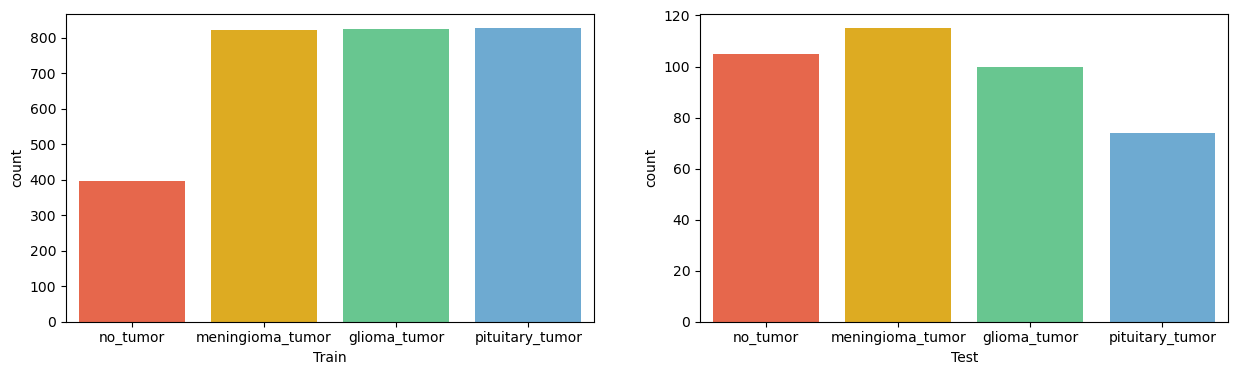

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
labelsss = ['Train', 'Test']
datasets = [train_labels, test_labels]
colors = ["#ff5733", "#fcba03", "#58d68d", "#5dade2"] 

for ax, label, dataset in zip(axes, labelsss, datasets):
    sns.countplot(x=dataset, ax=ax, palette=colors)
    ax.set_xlabel(label)

plt.show()

## One-Hot Encoding

In [125]:
y_train = pd.get_dummies(train_labels)
y_test = pd.get_dummies(test_labels)
labels=y_train.columns

In [126]:
labels

Index(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'], dtype='object')

## Data Augmentation

In [127]:
datagen = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images by up to 30 degrees
        width_shift_range=0.1,  # randomly shift images horizontally by up to 10% of the image width
        height_shift_range=0.1,  # randomly shift images vertically by up to 10% of the image height
        shear_range=0.2,  # randomly apply shearing transformations
        zoom_range=0.2,  # randomly zoom in on images by up to 20%
        horizontal_flip=True,  # randomly flip images horizontally
        fill_mode='nearest'  # fill any empty pixels with the nearest pixel value
)

datagen.fit(train_imgs)

# Utility Functions

In [128]:
def plot_graph(model_history):
    
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = model_history.history['accuracy']
    train_loss = model_history.history['loss']
    val_acc = model_history.history['val_accuracy']
    val_loss = model_history.history['val_loss']
    epochs_count = [i for i in range(len(train_acc))]

    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
            fontname='monospace', color='#111111', y=1, x=0.28, alpha=0.8)

    sns.despine()
    ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor='#1256A2', color='#4A90E2',
           label = 'Training Accuracy')
    ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor='#AED6F1', color='#4A90E2',
           label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor='#1256A2', color='#4A90E2',
            label='Training Loss')
    ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor='#AED6F1', color='#4A90E2',
           label='Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

def create_subplot_grid(plot_count, ncols=2, figsize=(20, 10)):
    nrows = math.ceil(plot_count / ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()
    for i in range(plot_count, len(axs)):
        fig.delaxes(axs[i])
    return fig, axs

def get_pred_figs(test_imgs, test_pred, y_test_encoded):
    fig, axs = create_subplot_grid(10,5)
    random_image_index = np.random.randint(test_imgs.shape[0], size=10)
    for count, ele in enumerate(random_image_index):
        axs[count]
        axs[count].imshow(test_imgs[ele])
        # color = ("Black" if test_pred[ele] == y_test_encoded[ele] else "red")
        color = ("Black" if test_pred[ele] == y_test_encoded[ele] else "red")
        axs[count].set_title(f"True: {test_labels[ele]}\nPredicted: { labels[test_pred[ele]] }", color=color)
        axs[count].axis('off')

# Model Building

## Custom CNN

In [129]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# model.summary()

In [130]:
epochs = 25
batch_size=32
logdir = 'logs_CustomCNN'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(train_imgs, y_train, validation_split=0.1,  epochs=epochs, batch_size=batch_size,
                    callbacks=[tensorboard_callback],  shuffle=True, verbose=1, workers=1)

Epoch 1/25


2023-04-18 20:30:10.078664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 16.0371 - accuracy: 0.5799

2023-04-18 20:30:15.112631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 63ms/step - loss: 16.0371 - accuracy: 0.5799 - val_loss: 0.3847 - val_accuracy: 0.8955
Epoch 2/25
81/81 [==============================] - 4s 54ms/step - loss: 0.3833 - accuracy: 0.8575 - val_loss: 0.3903 - val_accuracy: 0.8885
Epoch 3/25
81/81 [==============================] - 4s 52ms/step - loss: 0.1335 - accuracy: 0.9532 - val_loss: 0.2090 - val_accuracy: 0.9408
Epoch 4/25
81/81 [==============================] - 4s 51ms/step - loss: 0.0587 - accuracy: 0.9810 - val_loss: 0.2800 - val_accuracy: 0.9582
Epoch 5/25
81/81 [==============================] - 4s 51ms/step - loss: 0.0564 - accuracy: 0.9857 - val_loss: 0.2037 - val_accuracy: 0.9652
Epoch 6/25
81/81 [==============================] - 4s 52ms/step - loss: 0.0639 - accuracy: 0.9799 - val_loss: 0.2614 - val_accuracy: 0.9443
Epoch 7/25
81/81 [==============================] - 4s 51ms/step - loss: 0.0510 - accuracy: 0.9826 - val_loss: 0.3905 - val_accuracy: 0.8955
Epoch 8/25
81/81 [=====

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_18083/2329179175.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


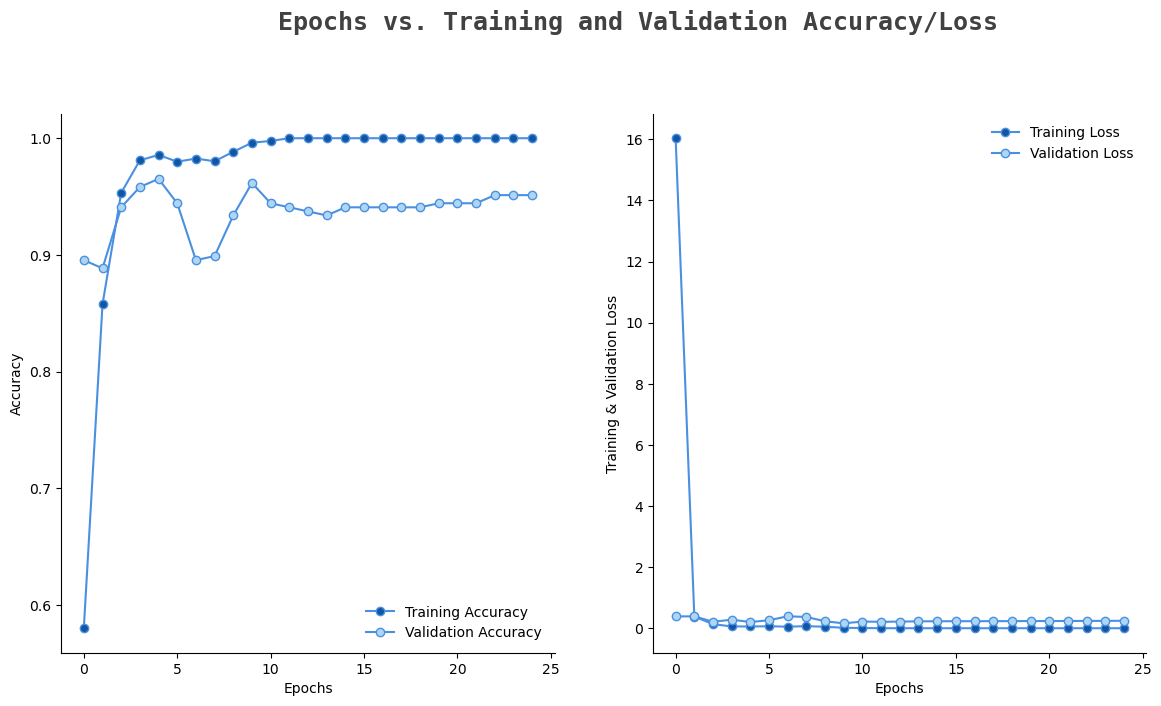

In [131]:
plot_graph(history)

In [132]:

test_pred_prob = model.predict(test_imgs) # pred_prob
test_pred = np.argmax(test_pred_prob,axis=1) # pred
y_test_encoded = np.argmax(y_test.to_numpy(),axis=1)
y_train_encoded = np.argmax(y_train.to_numpy(),axis=1)
train_pred_prob = model.predict(train_imgs)
train_pred = np.argmax(train_pred_prob,axis=1)

 4/13 [========>.....................] - ETA: 0s

2023-04-18 20:32:55.058292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 2s 23ms/step


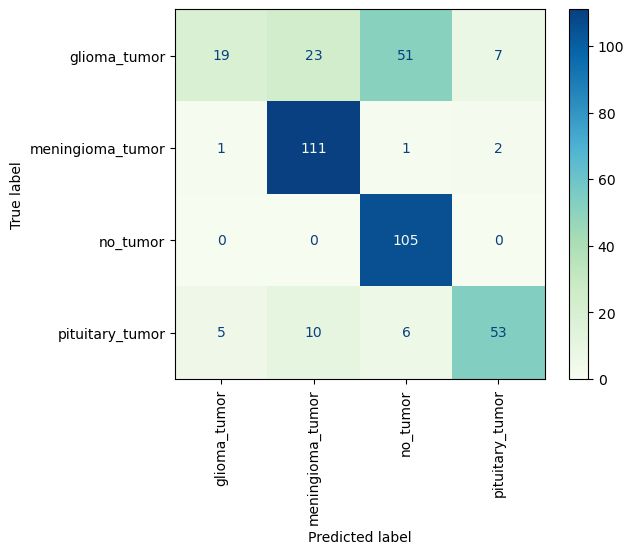

In [133]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, test_pred, display_labels=labels, 
                                        cmap='GnBu', xticks_rotation="vertical")

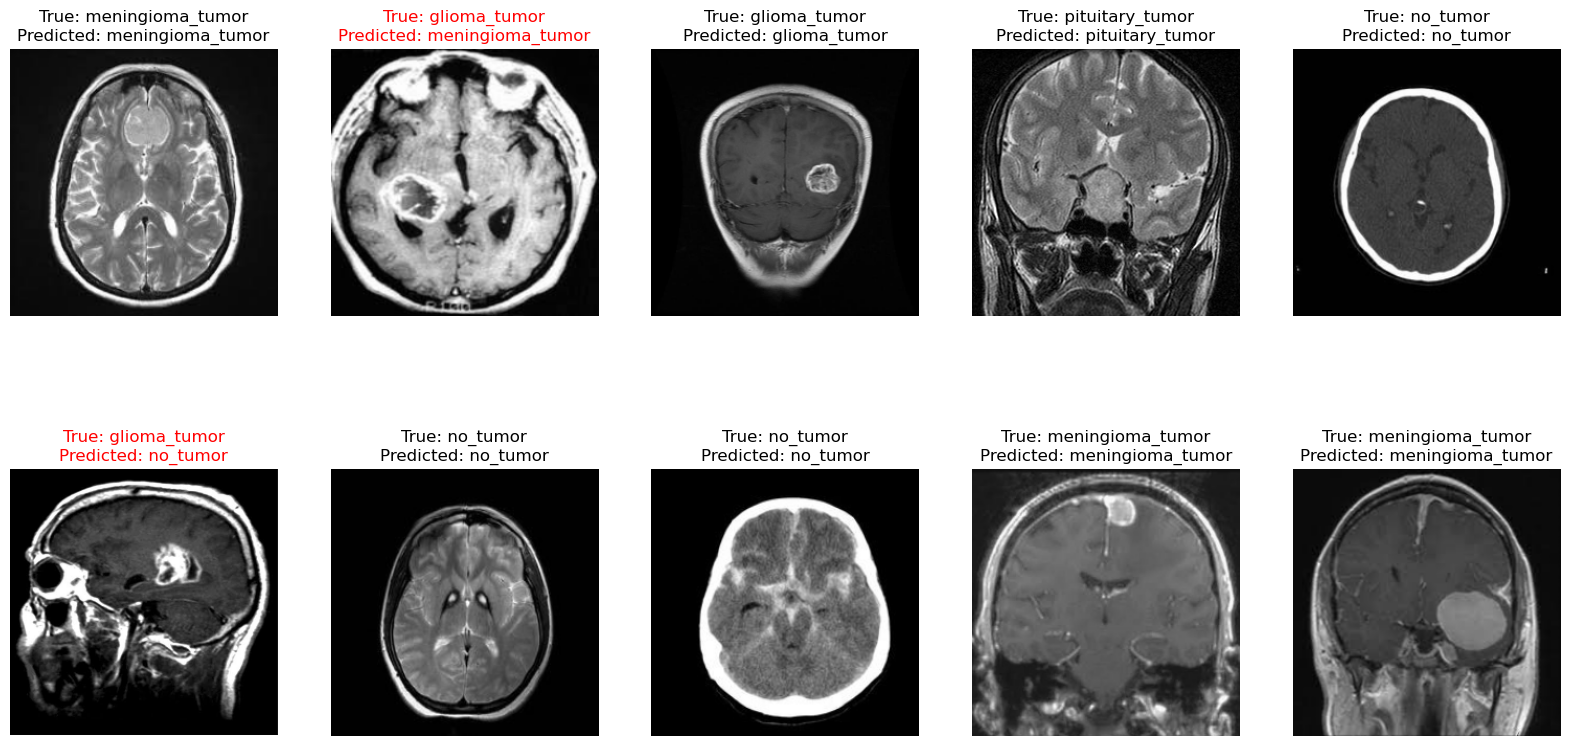

In [134]:
get_pred_figs(test_imgs, test_pred, y_test_encoded)

In [135]:
training_roc_auc = roc_auc_score(y_train, train_pred_prob,multi_class="ovo") 
print("Training:\n", classification_report(y_train_encoded,train_pred),"\n RUC-AUC:", training_roc_auc)

print()

testing_roc_auc = roc_auc_score(y_test, test_pred_prob,multi_class="ovo") 
print("Testing:\n", classification_report(y_test_encoded,test_pred),"\n RUC-AUC:", testing_roc_auc)

Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       826
           1       0.99      1.00      1.00       822
           2       0.99      1.00      1.00       395
           3       1.00      0.98      0.99       827

    accuracy                           1.00      2870
   macro avg       1.00      1.00      1.00      2870
weighted avg       1.00      1.00      1.00      2870
 
 RUC-AUC: 0.9998784762991759

Testing:
               precision    recall  f1-score   support

           0       0.76      0.19      0.30       100
           1       0.77      0.97      0.86       115
           2       0.64      1.00      0.78       105
           3       0.85      0.72      0.78        74

    accuracy                           0.73       394
   macro avg       0.76      0.72      0.68       394
weighted avg       0.75      0.73      0.68       394
 
 RUC-AUC: 0.870564962528322


## InceptionResNet50V2

In [136]:
inputs = layers.Input(shape=(None, None, 3))

# base ResNetV2 model
resnet_v2 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')(inputs)
x = layers.GlobalAveragePooling2D()(resnet_v2)
x = layers.Dropout(0.55)(x)
x = layers.Dense(60, activation='elu', kernel_initializer='glorot_normal')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()

In [137]:
epochs = 10
batch_size=32
logdir = 'logs_ResNet'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(train_imgs, y_train, validation_split=0.1,  epochs=epochs, batch_size=batch_size,
                    callbacks=[tensorboard_callback],  shuffle=True, verbose=1, workers=1)
model.save_weights('inceptionresnet50v2.h5')

Epoch 1/10


2023-04-18 20:34:09.580148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 0.7139 - accuracy: 0.7367

2023-04-18 20:35:03.002516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 60s 652ms/step - loss: 0.7139 - accuracy: 0.7367 - val_loss: 299.4463 - val_accuracy: 0.0000e+00
Epoch 2/10
81/81 [==============================] - 47s 578ms/step - loss: 0.4056 - accuracy: 0.8552 - val_loss: 4.5463 - val_accuracy: 0.4077
Epoch 3/10
81/81 [==============================] - 48s 591ms/step - loss: 0.3188 - accuracy: 0.8912 - val_loss: 8.2129 - val_accuracy: 0.0662
Epoch 4/10
81/81 [==============================] - 48s 588ms/step - loss: 0.2367 - accuracy: 0.9133 - val_loss: 15.5039 - val_accuracy: 0.0453
Epoch 5/10
81/81 [==============================] - 48s 589ms/step - loss: 0.1936 - accuracy: 0.9326 - val_loss: 4.0806 - val_accuracy: 0.0070
Epoch 6/10
81/81 [==============================] - 48s 591ms/step - loss: 0.1234 - accuracy: 0.9644 - val_loss: 1.9091 - val_accuracy: 0.3902
Epoch 7/10
81/81 [==============================] - 48s 592ms/step - loss: 0.1226 - accuracy: 0.9613 - val_loss: 0.7444 - val_accuracy: 0.8153
Epo

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_18083/2329179175.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


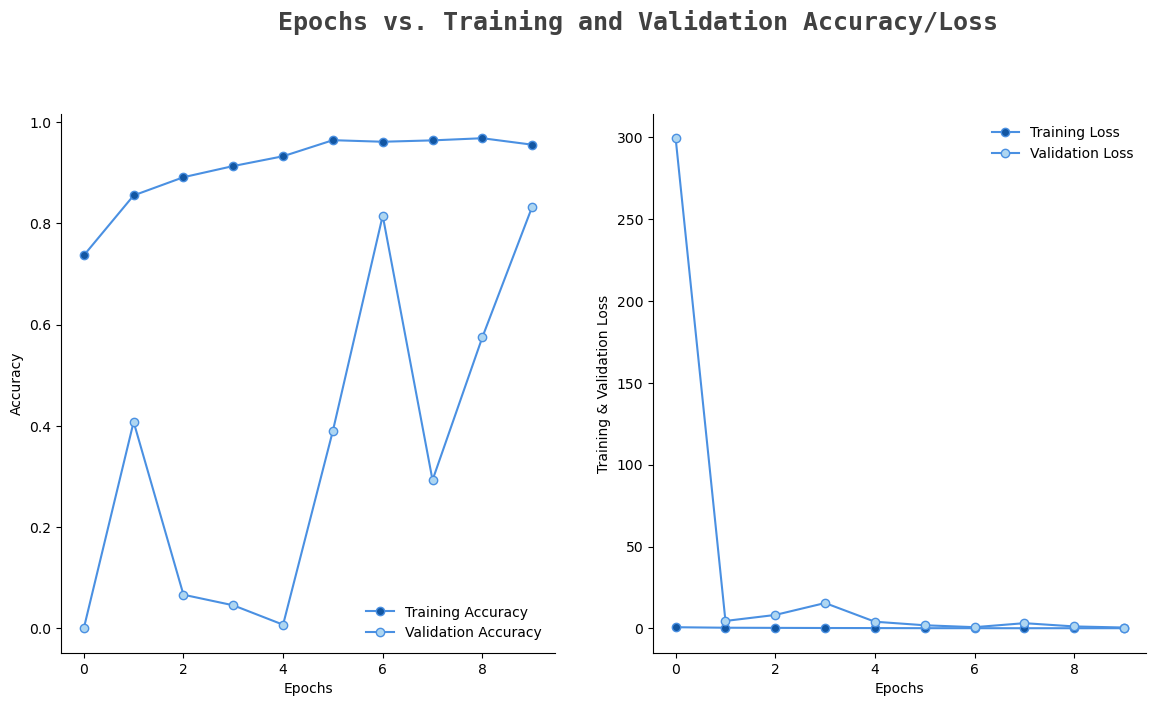

In [138]:
plot_graph(history)

In [139]:

test_pred_prob = model.predict(test_imgs)
test_pred = np.argmax(test_pred_prob,axis=1)
y_test_encoded = np.argmax(y_test.to_numpy(),axis=1)
y_train_encoded = np.argmax(y_train.to_numpy(),axis=1)
train_pred_prob = model.predict(train_imgs)
train_pred = np.argmax(train_pred_prob,axis=1)

2023-04-18 20:43:48.991344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 18s 196ms/step


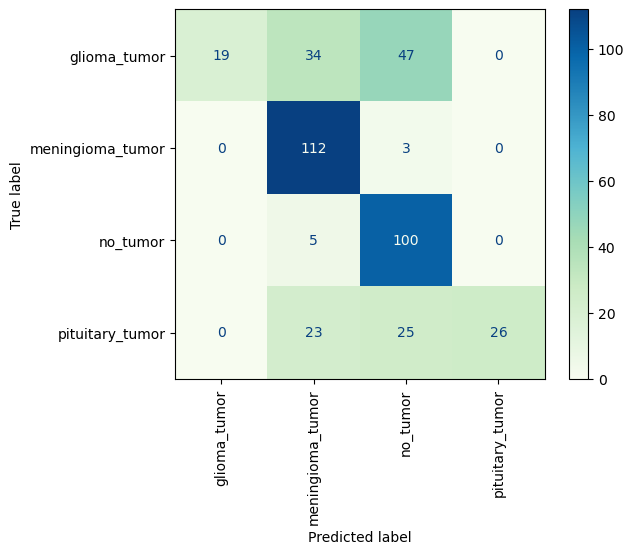

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, test_pred, display_labels=labels, 
                                        cmap='GnBu', xticks_rotation="vertical")

In [141]:
training_roc_auc = roc_auc_score(y_train, train_pred_prob,multi_class="ovo") 
print("Training:\n", classification_report(y_train_encoded,train_pred),"\n RUC-AUC:", training_roc_auc)

print()

testing_roc_auc = roc_auc_score(y_test, test_pred_prob,multi_class="ovo") 
print("Testing:\n", classification_report(y_test_encoded,test_pred),"\n RUC-AUC:", testing_roc_auc)

Training:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       826
           1       0.91      0.97      0.94       822
           2       0.88      0.95      0.91       395
           3       1.00      0.89      0.94       827

    accuracy                           0.95      2870
   macro avg       0.94      0.95      0.94      2870
weighted avg       0.95      0.95      0.95      2870
 
 RUC-AUC: 0.9955772459572448

Testing:
               precision    recall  f1-score   support

           0       1.00      0.19      0.32       100
           1       0.64      0.97      0.78       115
           2       0.57      0.95      0.71       105
           3       1.00      0.35      0.52        74

    accuracy                           0.65       394
   macro avg       0.80      0.62      0.58       394
weighted avg       0.78      0.65      0.60       394
 
 RUC-AUC: 0.8752405085001381


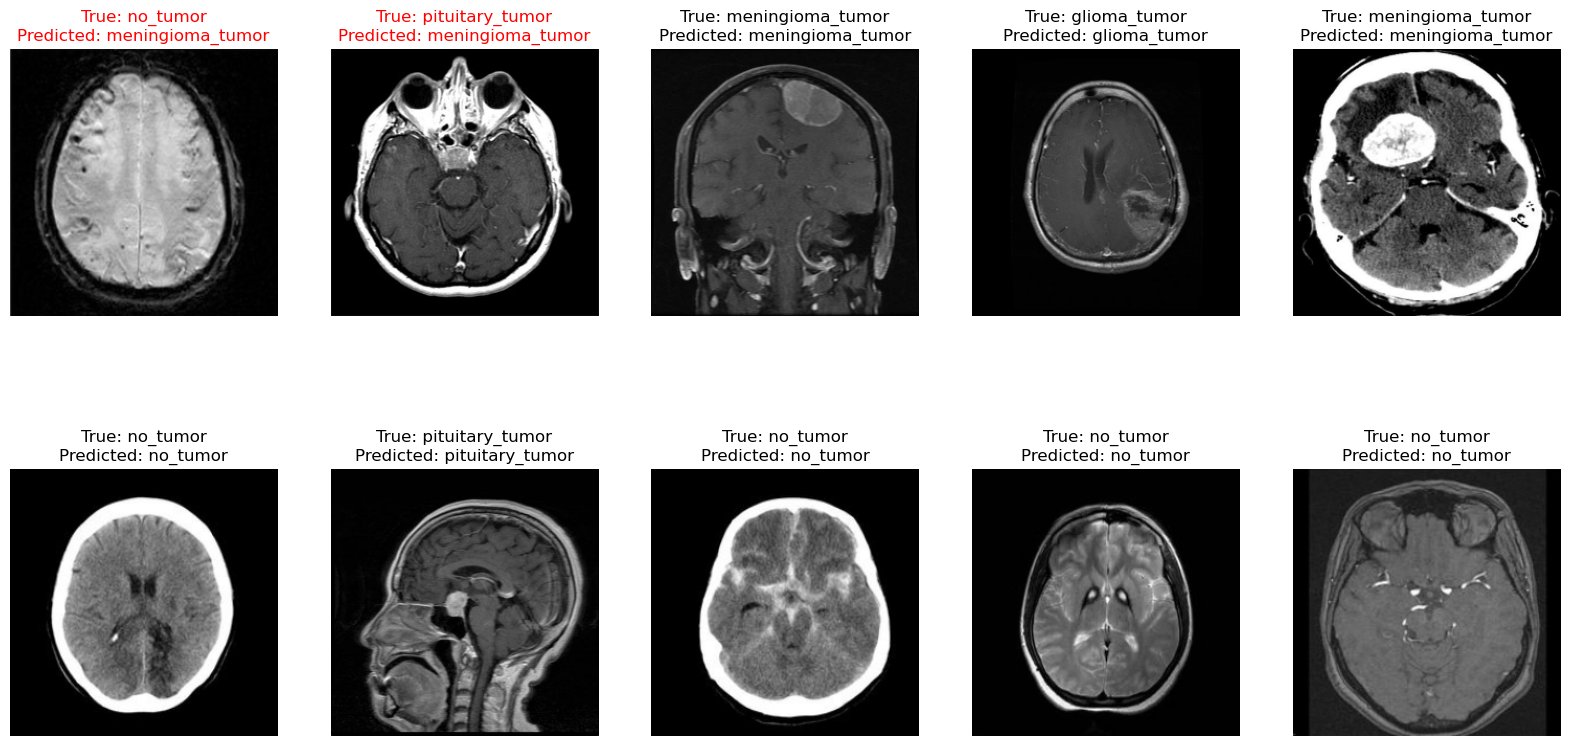

In [142]:
get_pred_figs(test_imgs, test_pred, y_test_encoded)

## MobileNet

In [145]:
base_model = MobileNet(weights='imagenet', include_top=False)

# build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [146]:
epochs = 15
batch_size=32
logdir = 'logs_MobileNet'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(train_imgs, y_train, validation_split=0.1,  epochs=epochs, batch_size=batch_size,
                    callbacks=[tensorboard_callback],  shuffle=True, verbose=1, workers=1)
model.save_weights('inceptionresnet50v2.h5')

Epoch 1/15


2023-04-18 20:48:36.037033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.6694

2023-04-18 20:48:45.050779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 11s 103ms/step - loss: 0.9190 - accuracy: 0.6694 - val_loss: 0.2431 - val_accuracy: 0.9373
Epoch 2/15
81/81 [==============================] - 7s 80ms/step - loss: 0.5164 - accuracy: 0.7906 - val_loss: 0.2609 - val_accuracy: 0.9164
Epoch 3/15
81/81 [==============================] - 6s 80ms/step - loss: 0.3774 - accuracy: 0.8533 - val_loss: 0.3377 - val_accuracy: 0.9129
Epoch 4/15
81/81 [==============================] - 6s 78ms/step - loss: 0.3382 - accuracy: 0.8699 - val_loss: 0.3017 - val_accuracy: 0.9129
Epoch 5/15
81/81 [==============================] - 6s 78ms/step - loss: 0.2805 - accuracy: 0.8912 - val_loss: 0.5418 - val_accuracy: 0.8293
Epoch 6/15
81/81 [==============================] - 6s 78ms/step - loss: 0.2959 - accuracy: 0.8858 - val_loss: 0.2373 - val_accuracy: 0.9338
Epoch 7/15
81/81 [==============================] - 6s 79ms/step - loss: 0.2086 - accuracy: 0.9292 - val_loss: 0.2173 - val_accuracy: 0.9443
Epoch 8/15
81/81 [====

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_18083/2329179175.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


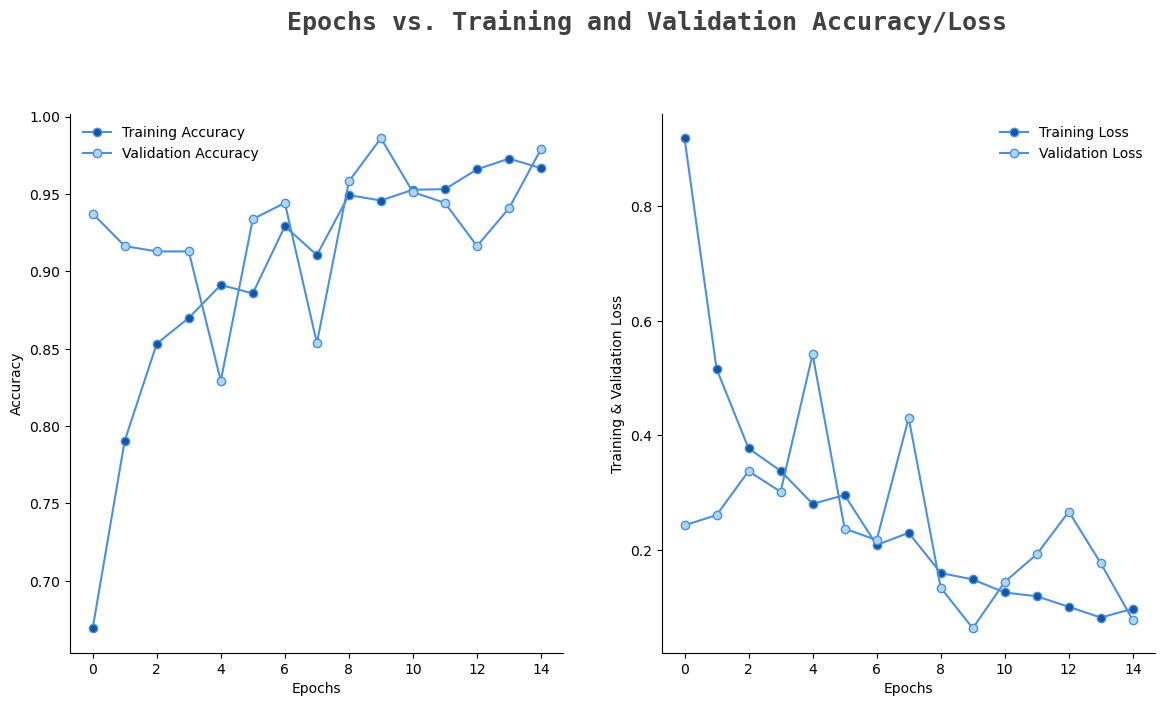

In [147]:
plot_graph(history)

In [148]:

test_pred_prob = model.predict(test_imgs)
test_pred = np.argmax(test_pred_prob,axis=1)
y_test_encoded = np.argmax(y_test.to_numpy(),axis=1)
y_train_encoded = np.argmax(y_train.to_numpy(),axis=1)
train_pred_prob = model.predict(train_imgs)
train_pred = np.argmax(train_pred_prob,axis=1)

2023-04-18 20:51:21.126739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 6s 65ms/step


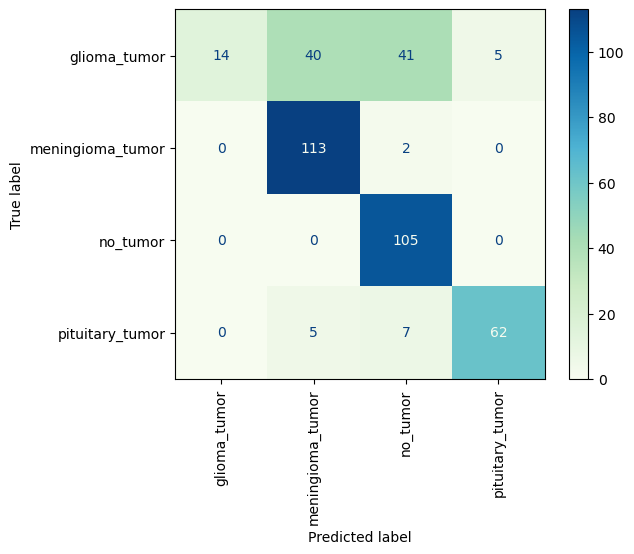

In [150]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, test_pred, display_labels=labels, 
                                        cmap='GnBu', xticks_rotation="vertical")

In [149]:
training_roc_auc = roc_auc_score(y_train, train_pred_prob,multi_class="ovo") 
print("Training:\n", classification_report(y_train_encoded,train_pred),"\n ROC-AUC:", training_roc_auc, '\n')

testing_roc_auc = roc_auc_score(y_test, test_pred_prob,multi_class="ovo") 
print("Testing:\n", classification_report(y_test_encoded,test_pred),"\n ROC-AUC:", testing_roc_auc)

Training:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88       826
           1       0.83      0.99      0.90       822
           2       1.00      0.99      1.00       395
           3       0.98      0.99      0.98       827

    accuracy                           0.93      2870
   macro avg       0.95      0.94      0.94      2870
weighted avg       0.94      0.93      0.93      2870
 
 ROC-AUC: 0.9987374235017838 

Testing:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25       100
           1       0.72      0.98      0.83       115
           2       0.68      1.00      0.81       105
           3       0.93      0.84      0.88        74

    accuracy                           0.75       394
   macro avg       0.83      0.74      0.69       394
weighted avg       0.82      0.75      0.68       394
 
 ROC-AUC: 0.898729563141832


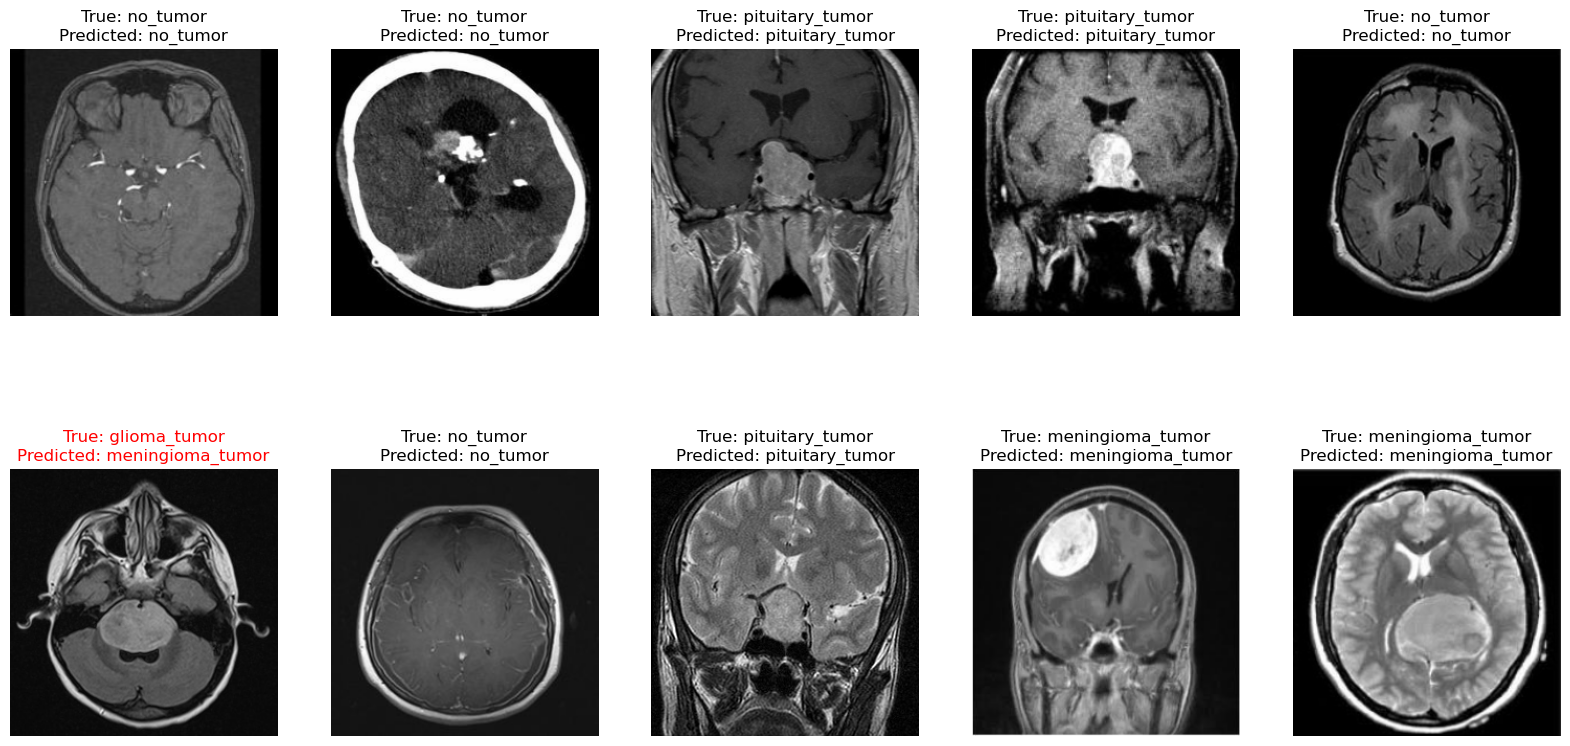

In [151]:
get_pred_figs(test_imgs, test_pred, y_test_encoded)